In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# PROBLEM STATEMENT
- Prevent Overstocking and Understocking of the itemsby Forecasting demand of items for next week, based on historical data.

# BUSINESS OBJECTIVES AND CONSTRAINTS
- Accuracy is very important
- Cost of Wrong forecasting can be very high
- No strict latency requirement
- Interpretability is partially important

# HYPOTHESIS GENERATION
- Does data have Trend Or Seasonal Pattern?
- Does sales have monthly pattern?
- Does large product size have more demand?
- Does the products on Feature have more sales?
- Does the products on Display have more sales?
- Does particular State/City have higher sales?
- Does Stores with large area have more sales compared to others?
- Does particular Manufacturer?Brand have more sales?
- Does Upscale have more sales?

# DATA DESCRIPTION
## TRAIN DATA
- WEEK_END_DATE - Week ending date
- STORE_NUM - Store Number
- UPC - (Universal Product Code) product specific identifier
- BASE_PRICE - Base price of item
- DISPLAY - Product was a part of in-store promotional display
- FEATURE - Product was in-store Circular
- UNITS - Units sold (target column)

## Product Data

- UPC - (Universal Product Code) product specific identifier
- DESCRIPTION - Product Description
- MANUFACTURER - Product manufacturer
- CATEGORY - Category of Product
- SUB-CATEGORY - Sub-Category of Product
- PRODUCT_SIZE - Quantity of Product

## Store Data

- STORE_ID - Store Number
- STORE_NAME - Name of Store
- ADDRES_CITY_NAME - City in which store is located
- ADDRESS_STATE_PROV_CODE - State
- MSA_CODE - (Metropolitan Statistical Area) Based on geographic Region and population density
- SEG_VALUE_NAME -  Store Segment Name
- PARKING_SPACE_QTY - Number of parking spaces in the store parking lot
- SALES_AREA_SIZE_NUM - Squre footage of Store
- AVG_WEEKLY_BASKETS - Average weekly baskets sold in the store.

## Loading Datasets

In [4]:
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DataSet/train.csv")
product_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DataSet/product_data.csv")
store_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DataSet/store_data.csv")

## We have three Datasets
- product_data : Contains details about the product
- store_data : Contains details of various stores associated with the retailer
- train_data : Contains transaction data of Products

In [5]:
store_data.shape, product_data.shape, train_data.shape

((76, 9), (30, 6), (232287, 7))

# Understanding and Validating the Data

## Train Data

In [6]:
train_data.head()


,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS
0,14-Jan-09,367,1111009477,1.57,0,0,13
1,14-Jan-09,367,1111009497,1.39,0,0,20
2,14-Jan-09,367,1111085319,1.88,0,0,14
3,14-Jan-09,367,1111085345,1.88,0,0,29
4,14-Jan-09,367,1111085350,1.98,0,0,35


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232287 entries, 0 to 232286
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   WEEK_END_DATE  232287 non-null  object 
 1   STORE_NUM      232287 non-null  int64  
 2   UPC            232287 non-null  int64  
 3   BASE_PRICE     232275 non-null  float64
 4   FEATURE        232287 non-null  int64  
 5   DISPLAY        232287 non-null  int64  
 6   UNITS          232287 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 12.4+ MB


- WEEK_END_DATE is of object type, we need to convert it into datetime
- Store number and Product code are int but they are Categorical variables .So we'll convert it into categorical

## WEEK_END_DATE

In [8]:
train_data['WEEK_END_DATE'] = pd.to_datetime(train_data['WEEK_END_DATE'])

/tmp/ipython-input-877244683.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data['WEEK_END_DATE'] = pd.to_datetime(train_data['WEEK_END_DATE'])


In [9]:
# Check for NUll Values
train_data['WEEK_END_DATE'].isnull().sum()

np.int64(0)

In [10]:
#Check for Minimum and Maximum date
train_data['WEEK_END_DATE'].min(), train_data['WEEK_END_DATE'].max()

(Timestamp('2009-01-14 00:00:00'), Timestamp('2011-09-28 00:00:00'))

- We have data from 14 January 2009 to 28 September 2011

In [11]:
# Check for total days
(train_data['WEEK_END_DATE'].max() - train_data['WEEK_END_DATE'].min())/7

Timedelta('141 days 00:00:00')

In [12]:
# Calculate Number of Weeks
train_data['WEEK_END_DATE'].nunique()

142

- Training Data is for 142 weeks.
- No missing values

In [13]:
# Day of Week
train_data['WEEK_END_DATE'].dt.day_name().value_counts()

,count
WEEK_END_DATE,
Wednesday,232287


- Train data is avaliable for every wednesday

# STORE_NUM and UPC

In [14]:
train_data[['STORE_NUM','UPC']].isna().sum()

,0
STORE_NUM,0
UPC,0


- No Null values in STORE_NUM and UPC

In [15]:
# Check for Unique Values
train_data[['STORE_NUM','UPC']].nunique()

,0
STORE_NUM,76
UPC,30


In [16]:
#train_data['STORE_NUM'].value_counts().sort_values()
train_data['STORE_NUM'].value_counts().min(), train_data['STORE_NUM'].value_counts().max()

(1676, 4098)

- We have 76 Unique Stores
- Every Store has minimum of 1676 transactions

# Does Each Store Hold Atleast one Entry per Week?

We have 76 Unique stores and 142 weeks of the data for the sales. If each Store is selling occupies atleast one row in the data, the minimum number of Unique rows should be 142*76 = 10792

In [17]:
train_data[['WEEK_END_DATE','STORE_NUM']].drop_duplicates().shape

(10792, 2)

Implies that each store is atleast selling 1 Product each week

In [18]:
train_data['UPC'].value_counts().min(), train_data['UPC'].value_counts().max()

(975, 10790)

# Is every Product sold atleast once, for all 142 weeks
142*30 = 4260

In [19]:
train_data[['UPC','WEEK_END_DATE']].drop_duplicates().shape

(4260, 2)

- We have 30 unique products in the training data
- There are 76 different stores associated with the retailer
- Both the variables do not have any missing values

In [20]:
# Calculating Average selling product every week per store
train_data.groupby(['STORE_NUM','WEEK_END_DATE'])['UNITS'].count().mean()


np.float64(21.523999258710155)

That means on an average, each week per Store we are selling 22 Products

# BASE_PRICE

In [21]:
train_data['BASE_PRICE'].isna().sum()

np.int64(12)

In [22]:
train_data['BASE_PRICE'].describe()

,BASE_PRICE
count,232275.000000
mean,3.345204
std,1.678181
min,0.860000
25%,1.950000
50%,2.990000
75%,4.080000
max,7.890000


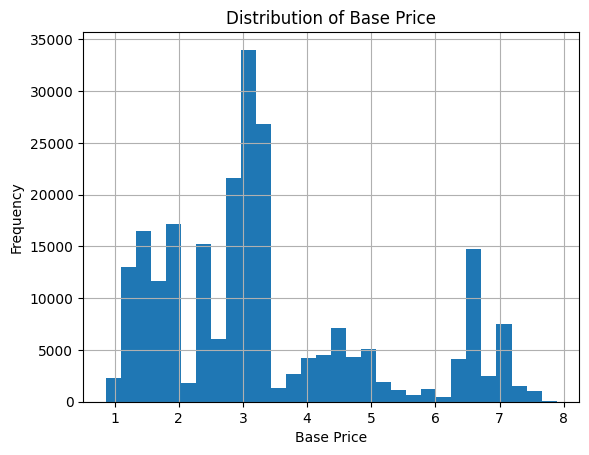

In [23]:
import matplotlib.pyplot as plt

train_data['BASE_PRICE'].hist(bins=30)
plt.xlabel('Base Price')
plt.ylabel('Frequency')
plt.title('Distribution of Base Price')
plt.show()

- The distribution of the base price. It seems that the base price is right-skewed.
- Range for BASE_PRICE is 1 dollar to 8 dollar

# FEATURE and DISPLAY

In [24]:
train_data[['DISPLAY','FEATURE']].isna().sum()

,0
DISPLAY,0
FEATURE,0


In [25]:
# Unique values in Feature and Display
train_data[['DISPLAY','FEATURE']].nunique()

,0
DISPLAY,2
FEATURE,2


In [26]:
# Datatype of Feature and Display
train_data[['DISPLAY','FEATURE']].dtypes

,0
DISPLAY,int64
FEATURE,int64


In [27]:
train_data['FEATURE'].value_counts(normalize=True)*100

,proportion
FEATURE,
0,90.011064
1,9.988936


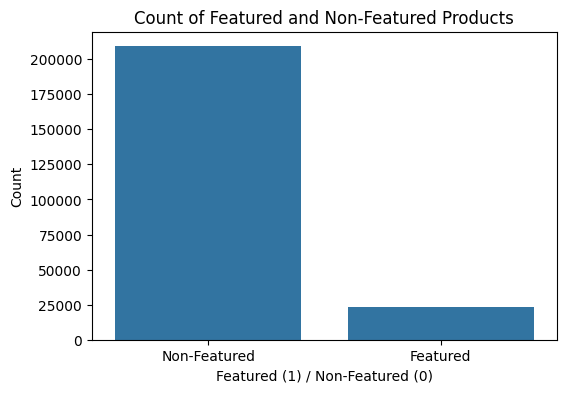

In [28]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='FEATURE', data=train_data)
plt.title('Count of Featured and Non-Featured Products')
plt.xlabel('Featured (1) / Non-Featured (0)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Featured', 'Featured'])
plt.show()

- Approximately 10% of Product are featured


In [29]:
train_data['DISPLAY'].value_counts(normalize=True)*100

,proportion
DISPLAY,
0,86.49989
1,13.50011


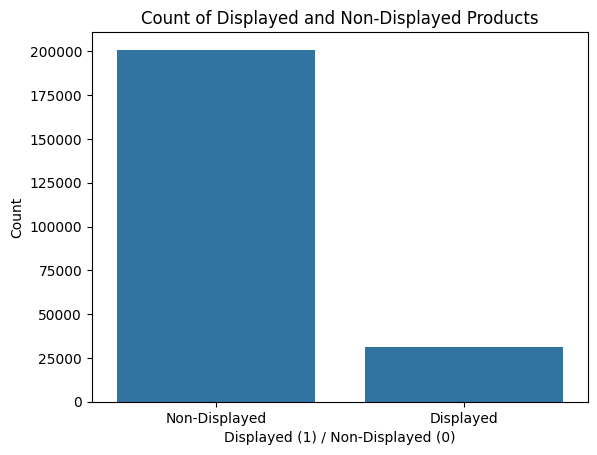

In [30]:
sns.countplot(x='DISPLAY', data=train_data)
plt.title('Count of Displayed and Non-Displayed Products')
plt.xlabel('Displayed (1) / Non-Displayed (0)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Displayed', 'Displayed'])
plt.show()

- Approximately 13% of the Product are on Display

In [31]:
pd.crosstab(train_data['DISPLAY'], train_data['FEATURE'],normalize='all')*100

FEATURE,0,1
DISPLAY,,
0,82.182386,4.317504
1,7.828677,5.671432


# UNITS

In [32]:
train_data['UNITS'].isna().sum()

np.int64(0)

- No null values

In [33]:
train_data['UNITS'].describe()

,UNITS
count,232287.000000
mean,28.063525
std,35.954341
min,0.000000
25%,9.000000
50%,18.000000
75%,34.000000
max,1800.000000


- The range of values is high
- Minimum units sold is 0 whereas maximum units sold is 1800
- A huge value between 75th percentile and the max value indicates presence of Outliers

How many Rows have 0 unit sold?

In [34]:
train_data[train_data['UNITS'] == 0]

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS
76752,2009-12-02,28909,31254742735,4.99,0,0,0


- Only one entry with 0 sold items
- It is maybe store is not selling particular products
- We will drop that value


In [35]:
train_data = train_data[train_data['UNITS'] != 0]

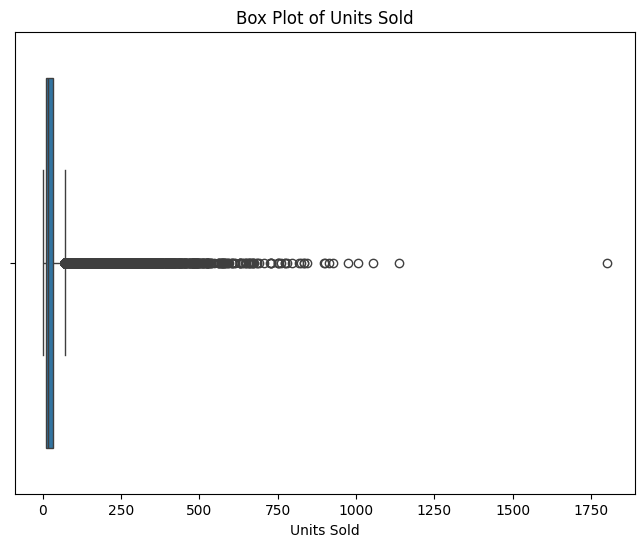

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x=train_data['UNITS'])
plt.xlabel('Units Sold')
plt.title('Box Plot of Units Sold')
plt.show()

In [37]:
Q1 = train_data['UNITS'].quantile(0.25)
Q3 = train_data['UNITS'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Lower Bound for Outliers: {lower_bound}")
print(f"Upper Bound for Outliers: {upper_bound}")

outliers = train_data[(train_data['UNITS'] < lower_bound) | (train_data['UNITS'] > upper_bound)]
print(f"\nNumber of outliers: {len(outliers)}")
print("\nOutliers:")
display(outliers.head())

Q1: 9.0
Q3: 34.0
IQR: 25.0
Lower Bound for Outliers: -28.5
Upper Bound for Outliers: 71.5

Number of outliers: 16483

Outliers:


,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS
7,2009-01-14,367,1111087398,4.00,0,1,72
17,2009-01-14,389,1111009497,1.37,0,0,78
23,2009-01-14,389,1111085350,1.96,0,0,118
29,2009-01-14,389,1600027564,2.70,1,0,147
41,2009-01-14,613,1111009477,1.23,0,1,76


#` HANDLING OUTLIERS`
- Capping
- Log Transformed
- Sqrt Transformed

In [38]:
import numpy as np

train_data['UNITS_log_transformed'] = np.log1p(train_data['UNITS'])
train_data['UNITS_sqrt_transformed'] = np.sqrt(train_data['UNITS'])

In [39]:
upper_bound = Q3 + 1.5 * IQR
train_data['UNITS_capped'] = train_data['UNITS'].apply(lambda x: upper_bound if x > upper_bound else x)

In [43]:
upper_bound

np.float64(71.5)

**Reasoning**:
Display the descriptive statistics for the 'UNITS_capped' column to observe the effect of capping.



In [40]:
train_data['UNITS_capped'].describe()

,UNITS_capped
count,232286.000000
mean,24.451872
std,20.124029
min,1.000000
25%,9.000000
50%,18.000000
75%,34.000000
max,71.500000


# Visulaizing the Outlier Detecting Method

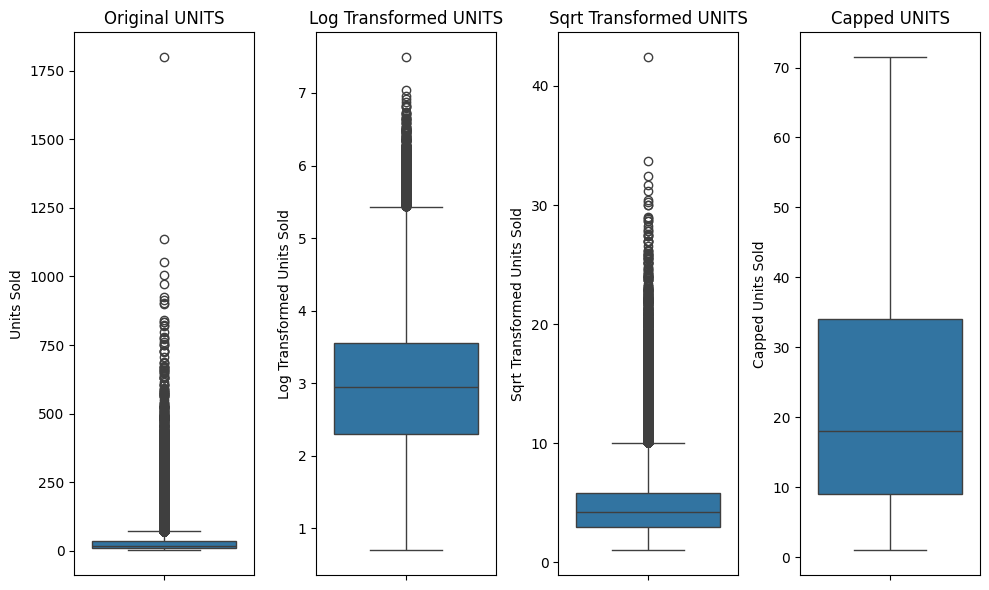

In [41]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 4, 1)
sns.boxplot(y=train_data['UNITS'])
plt.title('Original UNITS')
plt.ylabel('Units Sold')

plt.subplot(1, 4, 2)
sns.boxplot(y=train_data['UNITS_log_transformed'])
plt.title('Log Transformed UNITS')
plt.ylabel('Log Transformed Units Sold')

plt.subplot(1, 4, 3)
sns.boxplot(y=train_data['UNITS_sqrt_transformed'])
plt.title('Sqrt Transformed UNITS')
plt.ylabel('Sqrt Transformed Units Sold')

plt.subplot(1, 4, 4)
sns.boxplot(y=train_data['UNITS_capped'])
plt.title('Capped UNITS')
plt.ylabel('Capped Units Sold')

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   Two new columns were successfully added to the dataframe: 'UNITS\_log\_transformed' and 'UNITS\_sqrt\_transformed', containing the results of logarithmic and square root transformations applied to the 'UNITS' column.
*   Outliers in the 'UNITS' column were capped at the calculated upper bound of 71.5, and these capped values were stored in a new column called 'UNITS\_capped'.
*   Box plots visualized the impact of each outlier handling method: log and square root transformations compressed the distribution and reduced outlier prominence, while capping set extreme values to a fixed upper limit.
*   Based on visual assessment and the goal of demand forecasting, log transformation was selected as the most suitable outlier handling method as it normalized the distribution more effectively than capping and compressed outlier impact better than the square root transformation.

* But After log tranfomation no. of units had huge effect though the model perfomance will be enhanced but the output of the model will be the tranformed value, which cannot be interpreted by someone who just want to see the next week unit demand.



/tmp/ipython-input-2308117014.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['UNITS'].values, bins=25, kde=True)


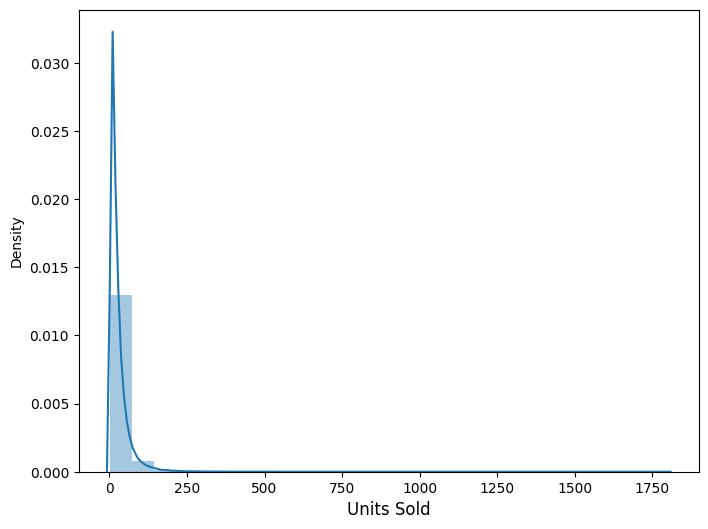

In [ ]:
plt.figure(figsize=(8,6))
sns.distplot(train_data['UNITS'].values, bins=25, kde=True)
plt.xlabel('Units Sold', fontsize=12)
plt.show()

/tmp/ipython-input-2613537061.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['UNITS_log_transformed'].values, bins=25, kde=True)


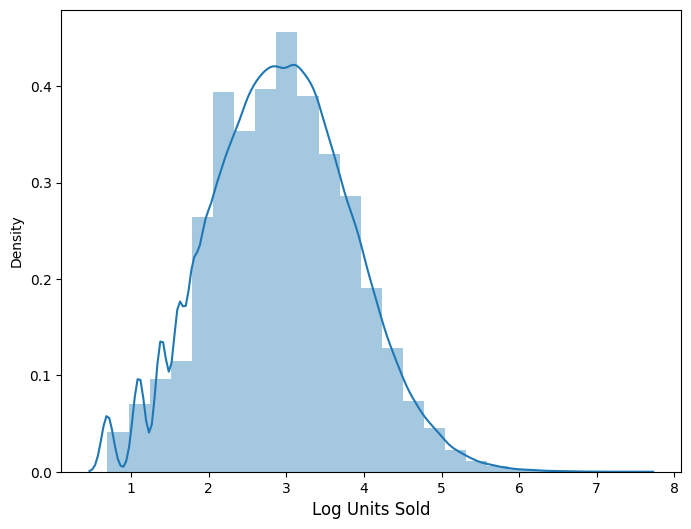

In [ ]:
plt.figure(figsize=(8,6))
sns.distplot(train_data['UNITS_log_transformed'].values, bins=25, kde=True)
plt.xlabel('Log Units Sold', fontsize=12)
plt.show()

- After log transformation,the distribution looks closer to a normal

# Understanding Produt Data

In [ ]:
product_data.head()

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,1111009477,PL MINI TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
1,1111009497,PL PRETZEL STICKS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
2,1111009507,PL TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
3,1111038078,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),500 ML
4,1111038080,PL ANTSPTC SPG MNT MTHWS,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),500 ML


In [ ]:
product_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   UPC           30 non-null     int64 
 1   DESCRIPTION   30 non-null     object
 2   MANUFACTURER  30 non-null     object
 3   CATEGORY      30 non-null     object
 4   SUB_CATEGORY  30 non-null     object
 5   PRODUCT_SIZE  30 non-null     object
dtypes: int64(1), object(5)
memory usage: 1.5+ KB


# Categorical Variables
- Check the unique values for categorical variables
- Are there any missing values in the variables?
- Is there any variables

UPC

In [ ]:
product_data['UPC'].nunique()

30

- Number of Unique values are same as in train

# CATEGORY

In [ ]:
product_data['CATEGORY'].nunique(),product_data['CATEGORY'].unique()

(4,
 array(['BAG SNACKS', 'ORAL HYGIENE PRODUCTS', 'COLD CEREAL',
        'FROZEN PIZZA'], dtype=object))

In [ ]:
product_data['CATEGORY'].isna().sum()

np.int64(0)

- No null or missing values

In [ ]:
product_data['CATEGORY'].value_counts()

,count
CATEGORY,
COLD CEREAL,9
BAG SNACKS,8
FROZEN PIZZA,7
ORAL HYGIENE PRODUCTS,6


- We have four product categories-
  - BAG SNACKS
  - ORAL HYGIENE PRODUCTS
  - COLD CEREAL
  - FROZEN PIZZA
  

# SUB_CATEGORY

In [ ]:
product_data['SUB_CATEGORY'].nunique(), product_data['SUB_CATEGORY'].unique()

(7,
 array(['PRETZELS', 'MOUTHWASHES (ANTISEPTIC)', 'ALL FAMILY CEREAL',
        'ADULT CEREAL', 'PIZZA/PREMIUM', 'MOUTHWASH/RINSES AND SPRAYS',
        'KIDS CEREAL'], dtype=object))

In [ ]:
product_data['SUB_CATEGORY'].isna().sum()

np.int64(0)

In [ ]:
product_data['SUB_CATEGORY'].value_counts()

,count
SUB_CATEGORY,
PRETZELS,8
PIZZA/PREMIUM,7
ALL FAMILY CEREAL,6
MOUTHWASHES (ANTISEPTIC),5
KIDS CEREAL,2
ADULT CEREAL,1
MOUTHWASH/RINSES AND SPRAYS,1


In [ ]:
product_data[['CATEGORY','SUB_CATEGORY']].drop_duplicates().sort_values(by='CATEGORY')

,CATEGORY,SUB_CATEGORY
0,BAG SNACKS,PRETZELS
5,COLD CEREAL,ALL FAMILY CEREAL
6,COLD CEREAL,ADULT CEREAL
19,COLD CEREAL,KIDS CEREAL
8,FROZEN PIZZA,PIZZA/PREMIUM
3,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC)
16,ORAL HYGIENE PRODUCTS,MOUTHWASH/RINSES AND SPRAYS


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('CATEGORY').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('SUB_CATEGORY').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['SUB_CATEGORY'].value_counts()
    for x_label, grp in _df_2.groupby('CATEGORY')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('CATEGORY')
_ = plt.ylabel('SUB_CATEGORY')

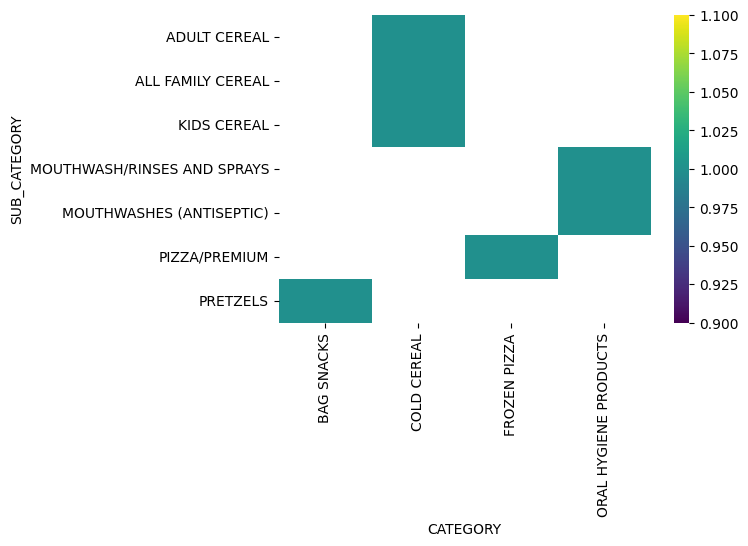

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(6, 4))
df_2dhist = pd.DataFrame({
    x_label: grp['SUB_CATEGORY'].value_counts()
    for x_label, grp in _df_2.groupby('CATEGORY')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('CATEGORY')
_ = plt.ylabel('SUB_CATEGORY')

The above 2-d Chart shows
- Cold Cereal has 3 sub categories
- Oral hygiene products have  sub categories
- Bag snacks & Frozen Pizza have just 1 sub category

# PRODUCT_SIZE

In [ ]:
product_data['PRODUCT_SIZE'].unique()

array(['15 OZ', '500 ML', '12.25 OZ', '20 OZ', '18 OZ', '32.7 OZ',
       '30.5 OZ', '29.6 OZ', '12 OZ', '16 OZ', '1 LT', '12.2 OZ',
       '29.8 OZ', '28.3 OZ', '22.7 OZ', '10 OZ'], dtype=object)

In [ ]:
product_data['PRODUCT_SIZE'].nunique()

16

In [ ]:
product_data['PRODUCT_SIZE'].value_counts()

,count
PRODUCT_SIZE,
15 OZ,4
16 OZ,4
1 LT,4
18 OZ,3
32.7 OZ,2
500 ML,2
12.25 OZ,2
20 OZ,1
29.6 OZ,1


In [ ]:
product_data['PRODUCT_SIZE'].isna().sum()

np.int64(0)

In [ ]:
product_data[['CATEGORY','SUB_CATEGORY','PRODUCT_SIZE']].drop_duplicates().sort_values(by ='CATEGORY')

,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,BAG SNACKS,PRETZELS,15 OZ
14,BAG SNACKS,PRETZELS,16 OZ
25,BAG SNACKS,PRETZELS,10 OZ
6,COLD CEREAL,ADULT CEREAL,20 OZ
7,COLD CEREAL,ALL FAMILY CEREAL,18 OZ
19,COLD CEREAL,KIDS CEREAL,15 OZ
20,COLD CEREAL,KIDS CEREAL,12.2 OZ
5,COLD CEREAL,ALL FAMILY CEREAL,12.25 OZ
13,COLD CEREAL,ALL FAMILY CEREAL,12 OZ
8,FROZEN PIZZA,PIZZA/PREMIUM,32.7 OZ


from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('CATEGORY').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('SUB_CATEGORY').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['SUB_CATEGORY'].value_counts()
    for x_label, grp in _df_5.groupby('CATEGORY')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('CATEGORY')
_ = plt.ylabel('SUB_CATEGORY')

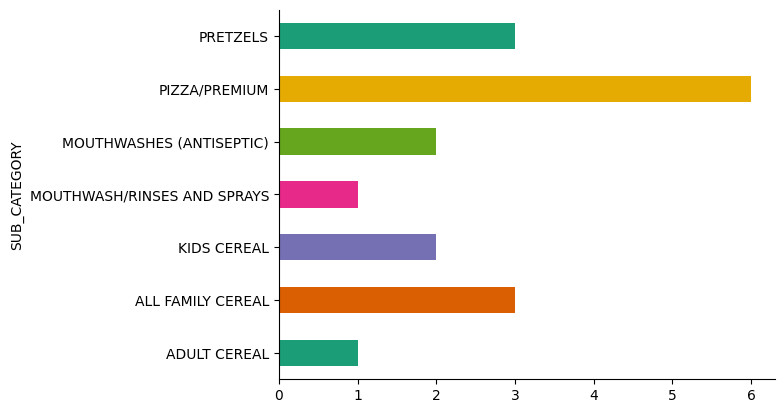

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('SUB_CATEGORY').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# DESCRIPTION


In [ ]:
product_data['DESCRIPTION'].isna().sum()

np.int64(0)

In [ ]:
product_data['DESCRIPTION'].unique(),product_data['DESCRIPTION'].nunique()

(array(['PL MINI TWIST PRETZELS', 'PL PRETZEL STICKS', 'PL TWIST PRETZELS',
        'PL BL MINT ANTSPTC RINSE', 'PL ANTSPTC SPG MNT MTHWS',
        'PL HONEY NUT TOASTD OATS', 'PL RAISIN BRAN',
        'PL BT SZ FRSTD SHRD WHT', 'PL SR CRUST SUPRM PIZZA',
        'PL SR CRUST 3 MEAT PIZZA', 'PL SR CRUST PEPPRN PIZZA',
        'GM HONEY NUT CHEERIOS', 'GM CHEERIOS', 'RLDGLD TINY TWISTS PRTZL',
        'RLDGLD PRETZEL STICKS', 'SCOPE ORIG MINT MOUTHWASH',
        'CREST PH CLN MINT RINSE', 'KELL BITE SIZE MINI WHEAT',
        'KELL FROSTED FLAKES', 'KELL FROOT LOOPS', 'DIGIORNO THREE MEAT',
        'DIGRN SUPREME PIZZA', 'DIGRN PEPP PIZZA',
        'FRSC BRCK OVN ITL PEP PZ', 'SNYDR PRETZEL RODS',
        'SNYDR SOURDOUGH NIBBLERS', 'SNYDR FF MINI PRETZELS',
        'LSTRNE CL MINT ANTSPTC MW', 'LSTRNE FRS BRST ANTSPC MW'],
       dtype=object),
 29)

- We have `29` descriptions for `30` products
- Almost all products have a unique description

In [44]:
product_data['DESCRIPTION'].value_counts()

,count
DESCRIPTION,
GM CHEERIOS,2
PL PRETZEL STICKS,1
PL TWIST PRETZELS,1
PL BL MINT ANTSPTC RINSE,1
PL MINI TWIST PRETZELS,1
PL ANTSPTC SPG MNT MTHWS,1
PL HONEY NUT TOASTD OATS,1
PL BT SZ FRSTD SHRD WHT,1
PL RAISIN BRAN,1


In [45]:
product_data.loc[product_data['DESCRIPTION'] == 'GM CHEERIOS']

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
12,1600027528,GM CHEERIOS,GENERAL MI,COLD CEREAL,ALL FAMILY CEREAL,18 OZ
13,1600027564,GM CHEERIOS,GENERAL MI,COLD CEREAL,ALL FAMILY CEREAL,12 OZ


- Same desctiption is avaliable for different prduct size

# MANUFACTURER

In [46]:
product_data['MANUFACTURER'].value_counts()

,count
MANUFACTURER,
PRIVATE LABEL,11
GENERAL MI,3
KELLOGG,3
SNYDER S,3
TOMBSTONE,3
P & G,2
FRITO LAY,2
WARNER,2
TONYS,1


In [48]:

product_data['MANUFACTURER'].nunique(),product_data['MANUFACTURER'].unique()

(9,
 array(['PRIVATE LABEL', 'GENERAL MI', 'FRITO LAY', 'P & G', 'KELLOGG',
        'TOMBSTONE', 'TONYS', 'SNYDER S', 'WARNER'], dtype=object))

In [49]:
product_data['MANUFACTURER'].isna().sum()

np.int64(0)

In [53]:
temp = product_data[['CATEGORY','MANUFACTURER']].drop_duplicates()
pd.crosstab([temp['CATEGORY']],temp['MANUFACTURER'])

MANUFACTURER,FRITO LAY,GENERAL MI,KELLOGG,P & G,PRIVATE LABEL,SNYDER S,TOMBSTONE,TONYS,WARNER
CATEGORY,,,,,,,,,
BAG SNACKS,1,0,0,0,1,1,0,0,0
COLD CEREAL,0,1,1,0,1,0,0,0,0
FROZEN PIZZA,0,0,0,0,1,0,1,1,0
ORAL HYGIENE PRODUCTS,0,0,0,1,1,0,0,0,1


- We have 4 unique categories of Product
- Each category has three Manufacturers
- Each category has one common maufacturer `'Private Label'`

# UNDERSTANDING `STORE DATA`

In [54]:
store_data.head()

,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12707
1,389,SILVERLAKE,ERLANGER,KY,17140,MAINSTREAM,408.0,46073,24767
2,613,EAST ALLEN,ALLEN,TX,19100,MAINSTREAM,464.0,64926,29386
3,623,HOUSTON,HOUSTON,TX,26420,MAINSTREAM,NaN,46930,36741
4,2277,ANDERSON TOWNE CTR,CINCINNATI,OH,17140,UPSCALE,NaN,81958,54053


In [55]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   STORE_ID                 76 non-null     int64  
 1   STORE_NAME               76 non-null     object 
 2   ADDRESS_CITY_NAME        76 non-null     object 
 3   ADDRESS_STATE_PROV_CODE  76 non-null     object 
 4   MSA_CODE                 76 non-null     int64  
 5   SEG_VALUE_NAME           76 non-null     object 
 6   PARKING_SPACE_QTY        25 non-null     float64
 7   SALES_AREA_SIZE_NUM      76 non-null     int64  
 8   AVG_WEEKLY_BASKETS       76 non-null     int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 5.5+ KB


#STORE_ID

In [56]:
store_data['STORE_ID'].isna().sum()

np.int64(0)

In [57]:
store_data['STORE_ID'].nunique()

76

#STORE_NAME

In [58]:
store_data['STORE_NAME'].isna().sum()

np.int64(0)

In [59]:
store_data['STORE_NAME'].nunique()

72

- The number of Unique Store Ids is not same as unique store names
- There might be some stores with same name located in different city

Let's Check for the Store with same name


In [60]:
store_data['STORE_NAME'].value_counts()

,count
STORE_NAME,
HOUSTON,4
MIDDLETOWN,2
SILVERLAKE,1
15TH & MADISON,1
ANDERSON TOWNE CTR,1
...,...
MAINEVILLE,1
SPRINGFIELD,1
DAYTON,1


In [64]:
store_counts = store_data['STORE_NAME'].value_counts()
stores_with_same_name = [name for name, count in store_counts.items() if count > 1]
print("Stores with the same name:")
print(stores_with_same_name)

Stores with the same name:
['HOUSTON', 'MIDDLETOWN']


- So, only `HOUSTON` and `MIDDLETOWN` are the names with repeated values.

In [65]:
store_data[store_data['STORE_NAME'] == 'HOUSTON']

,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
3,623,HOUSTON,HOUSTON,TX,26420,MAINSTREAM,NaN,46930,36741
9,2513,HOUSTON,HOUSTON,TX,26420,UPSCALE,NaN,61833,32423
54,21485,HOUSTON,KATY,TX,26420,MAINSTREAM,NaN,46369,26472
59,23327,HOUSTON,HOUSTON,TX,26420,MAINSTREAM,NaN,50722,30258


In [66]:
store_data[store_data['STORE_NAME'] == 'MIDDLETOWN']

,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
50,21221,MIDDLETOWN,MIDDLETOWN,OH,17140,VALUE,NaN,48128,17010
74,28909,MIDDLETOWN,MIDDLETOWN,OH,17140,MAINSTREAM,NaN,85876,28986


- The stores are not repeated but they are present at different location in same state.
- That's why they have different store_id

##### ADDRESS_CITY_NAME  and ADDRESS_STATE_PROV_CODE

In [67]:
store_data[['ADDRESS_CITY_NAME','ADDRESS_STATE_PROV_CODE']].isna().sum()

,0
ADDRESS_CITY_NAME,0
ADDRESS_STATE_PROV_CODE,0


In [68]:
store_data[['ADDRESS_CITY_NAME','ADDRESS_STATE_PROV_CODE']].nunique()

,0
ADDRESS_CITY_NAME,51
ADDRESS_STATE_PROV_CODE,4


- Stores are present in 4 states and 51 different cities

## Let's find out the number of stores in each of the state

In [72]:
store_data.groupby('ADDRESS_STATE_PROV_CODE')['STORE_ID'].count()

,STORE_ID
ADDRESS_STATE_PROV_CODE,
IN,1
KY,4
OH,30
TX,41


- Most stores are from Ohio and Texas almost 93%
- Few from Kentucky and Indiana

#### ADDRESS_CITY_NAME

In [73]:
store_data['ADDRESS_CITY_NAME'].value_counts()

,count
ADDRESS_CITY_NAME,
CINCINNATI,9
HOUSTON,8
MIDDLETOWN,3
SUGAR LAND,2
KATY,2
HAMILTON,2
DAYTON,2
LOVELAND,2
MCKINNEY,2


#### MSA_CODE

In [74]:
store_data['MSA_CODE'].value_counts()

,count
MSA_CODE,
17140,29
26420,21
19100,17
19380,4
17780,1
47540,1
43300,1
13140,1
44220,1


In [75]:
store_data['MSA_CODE'].isna().sum()

np.int64(0)

In [76]:
store_data['MSA_CODE'].nunique(),store_data['MSA_CODE'].unique()

(9, array([17140, 19100, 26420, 17780, 47540, 43300, 19380, 13140, 44220]))

#### PARKING_SPACE_QTY and SALES_AREA_SIZE_NUM

In [77]:
store_data[['PARKING_SPACE_QTY','SALES_AREA_SIZE_NUM']].isna().sum()

,0
PARKING_SPACE_QTY,51
SALES_AREA_SIZE_NUM,0


- Of total 76 stores, parking area of 51 is missing

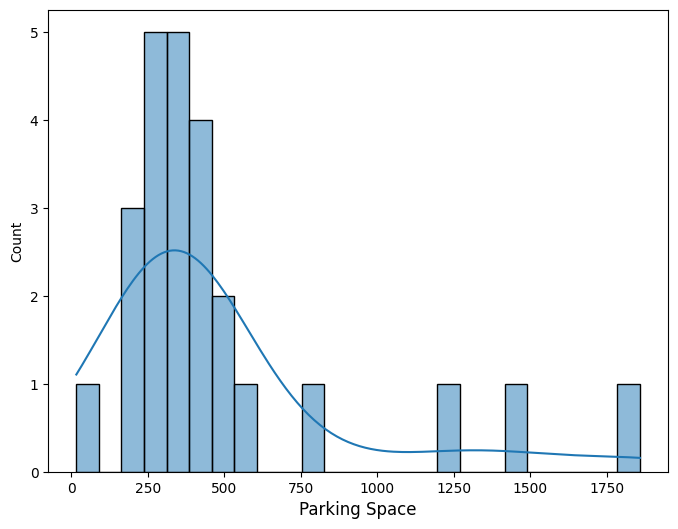

In [82]:
plt.figure(figsize=(8,6))
sns.histplot(store_data['PARKING_SPACE_QTY'].values, bins=25, kde=True)
plt.xlabel('Parking Space', fontsize=12)
plt.show()


- Most have area between `20k-70k sq feet`
- Only a small number of stores have area less than 20k or greater than 80k

#### AVG_WEEKLY_BASKETS

In [83]:
store_data['AVG_WEEKLY_BASKETS'].isna().sum()

np.int64(0)

In [84]:
store_data['AVG_WEEKLY_BASKETS'].describe()

,AVG_WEEKLY_BASKETS
count,76.000000
mean,24226.921053
std,8863.939362
min,10435.000000
25%,16983.500000
50%,24667.500000
75%,29398.500000
max,54053.000000


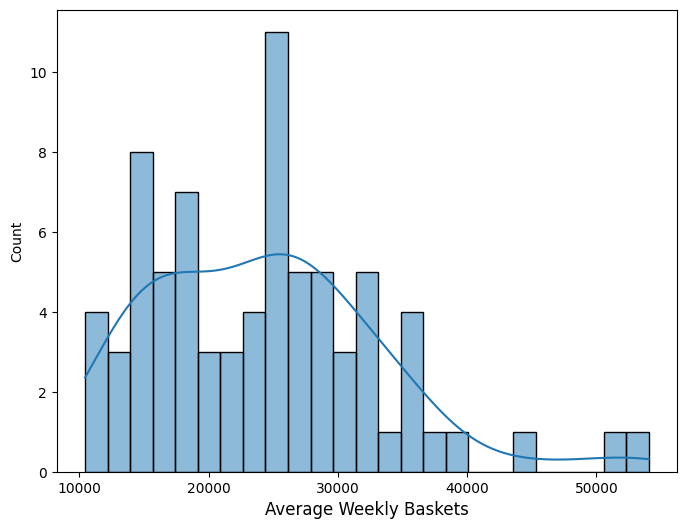

In [86]:
plt.figure(figsize=(8,6))
sns.histplot(store_data['AVG_WEEKLY_BASKETS'].values, bins=25, kde=True)
plt.xlabel('Average Weekly Baskets', fontsize=12)
plt.show()

#### Let's check avg_weekly_baskets sold for each state

In [88]:
store_data.groupby(['ADDRESS_STATE_PROV_CODE'])['AVG_WEEKLY_BASKETS'].mean().sort_values(ascending = False)

,AVG_WEEKLY_BASKETS
ADDRESS_STATE_PROV_CODE,
OH,26113.766667
TX,23234.195122
KY,21489.000000
IN,19275.000000


- `OHIO` and `TEXAS` have high average weekly baskets sold

#### SEG_VALUE_NAME

- **UPSCALE STORES**: Located in high income neighbourhoods and offer more high-end product
- **MAINSTREAM STORES**: Located in middle class areas, offering a mix of Upscale and value product
-**VALUE STORES**: Focus on low prices products targeting low income customers


In [89]:
store_data['SEG_VALUE_NAME'].isna().sum()

np.int64(0)

In [90]:
store_data['SEG_VALUE_NAME'].value_counts()

,count
SEG_VALUE_NAME,
MAINSTREAM,43
VALUE,19
UPSCALE,14


#### Lets's check average sales for each segment

In [94]:
store_data.groupby(['SEG_VALUE_NAME'])['AVG_WEEKLY_BASKETS'].mean().sort_values(ascending = False)

,AVG_WEEKLY_BASKETS
SEG_VALUE_NAME,
UPSCALE,28735.928571
MAINSTREAM,24024.093023
VALUE,21363.526316


- Sales for Upscale if highest as it located in high income neighbourhoods and offer more high-end products

`**Completed**`